# Mathematical Transshipment Toy Model (7-retailers):
$$\text{min} \space E[ h(S,\tilde{D})]$$<br>
where:
<br>
$$h(S,\tilde{D}) = \text{min} \sum_{i=1}^{7} $1*e_{i} + \sum_{i=1}^{7}\sum_{j=1}^{7} $0.5* t_{ij} + \sum_{i=1}^{7} $4*r_{i} \quad \text{with} \space  t_{ij} = 0, \text{if} \space i = j$$
<br>
such that: <br>
$$f_{i} + \sum_{j = 1, j\neq i}^{7} t_{ij} + e_{i} = s_{i} \quad \forall i = 1,...,7$$
<br>
$$f_{i} + \sum_{j=1, j\neq i}^{7} t_{ji} + r_{i}  = d_{i} \quad \forall i = 1,...,7$$
<br>
$$\sum_{i=1}^{7} r_{i} + \sum_{i=1}^{7} q_{i} = \sum_{i=1}^{7} d_{i} $$
<br>
$$e_{i} + q_{i} = s_{i} \quad \forall i = 1,...,7$$

In [ ]:
!pip install -q pyomo

     |████████████████████████████████| 9.5MB 12.6MB/s 
     |████████████████████████████████| 256kB 45.3MB/s 
     |████████████████████████████████| 51kB 3.8MB/s 
     |████████████████████████████████| 163kB 39.5MB/s 


In [ ]:
!apt-get install -y -qq glpk-utils

Selecting previously unselected package libsuitesparseconfig5:amd64.
(Reading database ... 160690 files and directories currently installed.)
Preparing to unpack .../libsuitesparseconfig5_1%3a5.1.2-2_amd64.deb ...
Unpacking libsuitesparseconfig5:amd64 (1:5.1.2-2) ...
Selecting previously unselected package libamd2:amd64.
Preparing to unpack .../libamd2_1%3a5.1.2-2_amd64.deb ...
Unpacking libamd2:amd64 (1:5.1.2-2) ...
Selecting previously unselected package libcolamd2:amd64.
Preparing to unpack .../libcolamd2_1%3a5.1.2-2_amd64.deb ...
Unpacking libcolamd2:amd64 (1:5.1.2-2) ...
Selecting previously unselected package libglpk40:amd64.
Preparing to unpack .../libglpk40_4.65-1_amd64.deb ...
Unpacking libglpk40:amd64 (4.65-1) ...
Selecting previously unselected package glpk-utils.
Preparing to unpack .../glpk-utils_4.65-1_amd64.deb ...
Unpacking glpk-utils (4.65-1) ...
Setting up libsuitesparseconfig5:amd64 (1:5.1.2-2) ...
Setting up libcolamd2:amd64 (1:5.1.2-2) ...
Setting up libamd2:amd64 

In [ ]:
import numpy as np
import random
import pyomo as pyo
import pandas as pd
from pyomo.environ import *
import pyomo.gdp as gdp
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import norm
from itertools import tee
import itertools
import time

## Demand Simulation

In [ ]:
def pairwise(iterable):
    a, b = tee(iterable)
    next(b, None)
    return zip(a, b)
"""
specify the mean and variance of the normal distribution and 
choose an odd number of n points to discretize the normal distribution (default n=3).
Function will return a tuple, first component being the list of values
equally spaced by standard deviation and an array of each value's
assigned normal probability weight in the second component. Each 
probability weight is computed from the CDF using midpoint quadrature so weights sum to 1.0. 
res is an optional granularity argument to allow range of possible values to include
values that are spaced in less than 1 standard deviation increments. However, using res values 
less than 1 may result in some errors in the total probability.
"""
def discretizeNormal(mu,sigma, n,res = 1):
    wts = []
    startpt = mu - n//2*sigma
    endpt = mu + n//2*sigma
    leftvals = np.arange(startpt,mu,res*sigma)
    rightvals = np.arange(mu, endpt + sigma, res*sigma)
    vals = np.concatenate((leftvals,rightvals))
    zscores = (vals - mu)/sigma
    zmidpts = (zscores[1:]+zscores[:-1])/2
    for i,j in pairwise(zmidpts):
        wts.append(np.diff(norm.cdf((i,j))).item())
    wts.insert(0,norm.cdf(zmidpts[0]))
    wts.insert(len(wts),norm.cdf(zmidpts[0]))
    return (vals,wts)

def simulateDemand(n):
    d, p = [], []
    d1, p1 = discretizeNormal(100,20,n) 
    d2, p2 = discretizeNormal(200,50,n)
    d3, p3 = discretizeNormal(150,30,n)
    d4, p4 = discretizeNormal(170,50,n)
    d5, p5 = discretizeNormal(180,40,n)
    d6, p6 = discretizeNormal(170,30,n)
    d7, p7 = discretizeNormal(170,50,n)  
    
    d = [d1,d2,d3,d4,d5,d6,d7]
    p = [p1,p2,p3,p4,p5,p6,p7]
    d = list(itertools.product(*d))
    p = list(itertools.product(*p))
    
    d = [list(tup) for tup in d]
    p = [list(tup) for tup in p]
    
    return d, p

In [ ]:
def solveModel(demand,svec):
    m = ConcreteModel()
    m.dual = Suffix(direction=Suffix.IMPORT)
    
    #primal decision variables
    m.e = Var([1,2,3,4,5,6,7], domain=NonNegativeReals)
    m.r = Var([1,2,3,4,5,6,7], domain=NonNegativeReals)
    m.t = Var(['12','13','14','15','16','17',\
               '21','23','24','25','26','27',\
               '31','32','34','35','36','37',\
               '41','42','43','45','46','47',\
               '51','52','53','54','56','57',\
               '61','62','63','64','65','67',\
               '71','72','73','74','75','76'],domain=NonNegativeReals)
    
    #q and f variables
    m.f = Var([1,2,3,4,5,6,7],domain=NonNegativeReals)
    m.q = Var([1,2,3,4,5,6,7],domain=NonNegativeReals)

    #assign feasible s values from previous solve
    s = svec
    
    #assign simulated demand to model.d
    d = demand
    
    #Objective
    m.OBJ = Objective(expr=m.e[1]+m.e[2]+m.e[3]+m.e[4]+m.e[5]+m.e[6]+m.e[7]\
                          +0.5*(m.t['12']+m.t['13']+m.t['14']+m.t['15']+m.t['16']+m.t['17']\
                                +m.t['21']+m.t['23']+m.t['24']+m.t['25']+m.t['26']+m.t['27']\
                                +m.t['31']+m.t['32']+m.t['34']+m.t['35']+m.t['36']+m.t['37']\
                                +m.t['41']+m.t['42']+m.t['43']+m.t['45']+m.t['46']+m.t['47']\
                                +m.t['51']+m.t['52']+m.t['53']+m.t['54']+m.t['56']+m.t['57']\
                                +m.t['61']+m.t['62']+m.t['63']+m.t['64']+m.t['65']+m.t['67']\
                                +m.t['71']+m.t['72']+m.t['73']+m.t['74']+m.t['75']+m.t['76'])\
                      +4*(m.r[1]+m.r[2]+m.r[3]+m.r[4]+m.r[5]+m.r[6]+m.r[7]),sense=minimize)
    
    #s order-up-to constraints
    m.Constraint1 = Constraint(expr= m.f[1]+m.t['12']+m.t['13']+m.t['14']+m.t['15']+m.t['16']+m.t['17']+m.e[1]==s[0])
    m.Constraint2 = Constraint(expr= m.f[2]+m.t['21']+m.t['23']+m.t['24']+m.t['25']+m.t['26']+m.t['27']+m.e[2]==s[1])
    m.Constraint3 = Constraint(expr= m.f[3]+m.t['31']+m.t['32']+m.t['34']+m.t['35']+m.t['36']+m.t['37']+m.e[3]==s[2])
    m.Constraint4 = Constraint(expr= m.f[4]+m.t['41']+m.t['42']+m.t['43']+m.t['45']+m.t['46']+m.t['47']+m.e[4]==s[3])
    m.Constraint5 = Constraint(expr= m.f[5]+m.t['51']+m.t['52']+m.t['53']+m.t['54']+m.t['56']+m.t['57']+m.e[5]==s[4])
    m.Constraint6 = Constraint(expr= m.f[6]+m.t['61']+m.t['62']+m.t['63']+m.t['64']+m.t['65']+m.t['67']+m.e[6]==s[5])
    m.Constraint7 = Constraint(expr= m.f[7]+m.t['71']+m.t['72']+m.t['73']+m.t['74']+m.t['75']+m.t['76']+m.e[7]==s[6])

    #d demand constraints where d1,d2,d3 come from the simulated draws from discretized normal
    m.Constraint8 = Constraint(expr= m.f[1]+m.t['21']+m.t['31']+m.t['41']+m.t['51']+m.t['61']+m.t['71']+m.r[1]==d[0])
    m.Constraint9 = Constraint(expr= m.f[2]+m.t['12']+m.t['32']+m.t['42']+m.t['52']+m.t['62']+m.t['72']+m.r[2]==d[1])
    m.Constraint10 = Constraint(expr= m.f[3]+m.t['13']+m.t['23']+m.t['43']+m.t['53']+m.t['63']+m.t['73']+m.r[3]==d[2])
    m.Constraint11 = Constraint(expr= m.f[4]+m.t['14']+m.t['24']+m.t['34']+m.t['54']+m.t['64']+m.t['74']+m.r[4]==d[3])
    m.Constraint12 = Constraint(expr= m.f[5]+m.t['15']+m.t['25']+m.t['35']+m.t['45']+m.t['65']+m.t['75']+m.r[5]==d[4])
    m.Constraint13 = Constraint(expr= m.f[6]+m.t['16']+m.t['26']+m.t['36']+m.t['46']+m.t['56']+m.t['76']+m.r[6]==d[5])
    m.Constraint14 = Constraint(expr= m.f[7]+m.t['17']+m.t['27']+m.t['37']+m.t['47']+m.t['57']+m.t['67']+m.r[7]==d[6])

    #total constraints
    m.Constraint15 = Constraint(expr=m.r[1]+m.r[2]+m.r[3]+m.r[4]+m.r[5]+m.r[6]+m.r[7]\
                                  +m.q[1]+m.q[2]+m.q[3]+m.q[4]+m.q[5]+m.q[6]+m.q[7]\
                               ==d[0]+d[1]+d[2]+d[3]+d[4]+d[5]+d[6])

    #ending inventory plus replenishment constraint
    m.Constraint16 = Constraint(expr=m.e[1]+m.q[1]==s[0])
    m.Constraint17 = Constraint(expr=m.e[2]+m.q[2]==s[1])
    m.Constraint18 = Constraint(expr=m.e[3]+m.q[3]==s[2])
    m.Constraint19 = Constraint(expr=m.e[4]+m.q[4]==s[3])
    m.Constraint20 = Constraint(expr=m.e[5]+m.q[5]==s[4])
    m.Constraint21 = Constraint(expr=m.e[6]+m.q[6]==s[5])
    m.Constraint22 = Constraint(expr=m.e[7]+m.q[7]==s[6])

    opt = SolverFactory('glpk')
    opt.solve(m)

    return m

In [ ]:
def benders_lp(constraint_list):
    b = ConcreteModel()
    b.dual = Suffix(direction=Suffix.IMPORT)

    #primal decision variables
    b.s = Var([1,2,3,4,5,6,7], domain=NonNegativeReals)
    b.eta = Var(domain=NonNegativeReals)

    #constraint 
    b.constraints = ConstraintList()
    for cons in constraint_list:
        b.constraints.add(expr=cons[0] + cons[1][0]*b.s[1] + cons[1][1]*b.s[2] + cons[1][2]*b.s[3] \
                          + cons[1][3]*b.s[4] + cons[1][4]*b.s[5] + cons[1][5]*b.s[6] \
                          + cons[1][6]*b.s[7] <= b.eta)
    
    #Objective
    b.OBJ = Objective(expr=b.eta, sense=minimize)
    
    #Solve
    opt = SolverFactory('glpk')
    opt.solve(b)
    return b.OBJ(), list(b.s.get_values().values())

Get Initial Feasible S-vector from primal solve with all demands set to means

In [ ]:
m1 = ConcreteModel()
m1.dual = Suffix(direction=Suffix.IMPORT)

#primal decision variables
m1.e = Var([1,2,3,4,5,6,7], domain=NonNegativeReals)
m1.r = Var([1,2,3,4,5,6,7], domain=NonNegativeReals)
m1.t = Var(['12','13','14','15','16','17',\
            '21','23','24','25','26','27',\
            '31','32','34','35','36','37',\
            '41','42','43','45','46','47',\
            '51','52','53','54','56','57',\
            '61','62','63','64','65','67',\
            '71','72','73','74','75','76'],domain=NonNegativeReals)

#q and f variables
m1.f = Var([1,2,3,4,5,6,7],domain=NonNegativeReals)
m1.q = Var([1,2,3,4,5,6,7],domain=NonNegativeReals)

#assign feasible s values from previous solve
m1.s = Var([1,2,3,4,5,6,7],domain=NonNegativeReals)

#assign initial demand to model.d
d = [100,200,150,170,180,170,170]

#Objective
m1.OBJ = Objective(expr=m1.e[1]+m1.e[2]+m1.e[3]+m1.e[4]+m1.e[5]+m1.e[6]+m1.e[7]\
                      +0.5*(m1.t['12']+m1.t['13']+m1.t['14']+m1.t['15']+m1.t['16']+m1.t['17']\
                            +m1.t['21']+m1.t['23']+m1.t['24']+m1.t['25']+m1.t['26']+m1.t['27']\
                            +m1.t['31']+m1.t['32']+m1.t['34']+m1.t['35']+m1.t['36']+m1.t['37']\
                            +m1.t['41']+m1.t['42']+m1.t['43']+m1.t['45']+m1.t['46']+m1.t['47']\
                            +m1.t['51']+m1.t['52']+m1.t['53']+m1.t['54']+m1.t['56']+m1.t['57']\
                            +m1.t['61']+m1.t['62']+m1.t['63']+m1.t['64']+m1.t['65']+m1.t['67']\
                            +m1.t['71']+m1.t['72']+m1.t['73']+m1.t['74']+m1.t['75']+m1.t['76'])\
                  +4*(m1.r[1]+m1.r[2]+m1.r[3]+m1.r[4]+m1.r[5]+m1.r[6]+m1.r[7]),sense=minimize)

#s order-up-to constraints
m1.Constraint1 = Constraint(expr= m1.f[1]+m1.t['12']+m1.t['13']+m1.t['14']+m1.t['15']+m1.t['16']+m1.t['17']+m1.e[1]==m1.s[1])
m1.Constraint2 = Constraint(expr= m1.f[2]+m1.t['21']+m1.t['23']+m1.t['24']+m1.t['25']+m1.t['26']+m1.t['27']+m1.e[2]==m1.s[2])
m1.Constraint3 = Constraint(expr= m1.f[3]+m1.t['31']+m1.t['32']+m1.t['34']+m1.t['35']+m1.t['36']+m1.t['37']+m1.e[3]==m1.s[3])
m1.Constraint4 = Constraint(expr= m1.f[4]+m1.t['41']+m1.t['42']+m1.t['43']+m1.t['45']+m1.t['46']+m1.t['47']+m1.e[4]==m1.s[4])
m1.Constraint5 = Constraint(expr= m1.f[5]+m1.t['51']+m1.t['52']+m1.t['53']+m1.t['54']+m1.t['56']+m1.t['57']+m1.e[5]==m1.s[5])
m1.Constraint6 = Constraint(expr= m1.f[6]+m1.t['61']+m1.t['62']+m1.t['63']+m1.t['64']+m1.t['65']+m1.t['67']+m1.e[6]==m1.s[6])
m1.Constraint7 = Constraint(expr= m1.f[7]+m1.t['71']+m1.t['72']+m1.t['73']+m1.t['74']+m1.t['75']+m1.t['76']+m1.e[7]==m1.s[7])

#d demand constraints where d1,d2,d3 come from the simulated draws from discretized normal
m1.Constraint8 = Constraint(expr= m1.f[1]+m1.t['21']+m1.t['31']+m1.t['41']+m1.t['51']+m1.t['61']+m1.t['71']+m1.r[1]==d[0])
m1.Constraint9 = Constraint(expr= m1.f[2]+m1.t['12']+m1.t['32']+m1.t['42']+m1.t['52']+m1.t['62']+m1.t['72']+m1.r[2]==d[1])
m1.Constraint10= Constraint(expr= m1.f[3]+m1.t['13']+m1.t['23']+m1.t['43']+m1.t['53']+m1.t['63']+m1.t['73']+m1.r[3]==d[2])
m1.Constraint11= Constraint(expr= m1.f[4]+m1.t['14']+m1.t['24']+m1.t['34']+m1.t['54']+m1.t['64']+m1.t['74']+m1.r[4]==d[3])
m1.Constraint12= Constraint(expr= m1.f[5]+m1.t['15']+m1.t['25']+m1.t['35']+m1.t['45']+m1.t['65']+m1.t['75']+m1.r[5]==d[4])
m1.Constraint13= Constraint(expr= m1.f[6]+m1.t['16']+m1.t['26']+m1.t['36']+m1.t['46']+m1.t['56']+m1.t['76']+m1.r[6]==d[5])
m1.Constraint14= Constraint(expr= m1.f[7]+m1.t['17']+m1.t['27']+m1.t['37']+m1.t['47']+m1.t['57']+m1.t['67']+m1.r[7]==d[6])

#total constraints
m1.Constraint15 = Constraint(expr=m1.r[1]+m1.r[2]+m1.r[3]+m1.r[4]+m1.r[5]+m1.r[6]+m1.r[7]\
                              +m1.q[1]+m1.q[2]+m1.q[3]+m1.q[4]+m1.q[5]+m1.q[6]+m1.q[7]\
                            ==d[0]+d[1]+d[2]+d[3]+d[4]+d[5]+d[6])

#ending inventory plus replenishment constraint
m1.Constraint16 = Constraint(expr=m1.e[1]+m1.q[1]==m1.s[1])
m1.Constraint17 = Constraint(expr=m1.e[2]+m1.q[2]==m1.s[2])
m1.Constraint18 = Constraint(expr=m1.e[3]+m1.q[3]==m1.s[3])
m1.Constraint19 = Constraint(expr=m1.e[4]+m1.q[4]==m1.s[4])
m1.Constraint20 = Constraint(expr=m1.e[5]+m1.q[5]==m1.s[5])
m1.Constraint21 = Constraint(expr=m1.e[6]+m1.q[6]==m1.s[6])
m1.Constraint22 = Constraint(expr=m1.e[7]+m1.q[7]==m1.s[7])

opt = SolverFactory('glpk')
opt.solve(m1)

m1.s.display()

s : Size=7, Index=s_index
    Key : Lower : Value : Upper : Fixed : Stale : Domain
      1 :     0 : 100.0 :  None : False : False : NonNegativeReals
      2 :     0 : 200.0 :  None : False : False : NonNegativeReals
      3 :     0 : 150.0 :  None : False : False : NonNegativeReals
      4 :     0 : 170.0 :  None : False : False : NonNegativeReals
      5 :     0 : 180.0 :  None : False : False : NonNegativeReals
      6 :     0 : 170.0 :  None : False : False : NonNegativeReals
      7 :     0 : 170.0 :  None : False : False : NonNegativeReals


In [ ]:
s_ini =[]
for i in m1.s.extract_values():
    s_ini.append(m1.s.extract_values()[i])
s_ini

[100.0, 200.0, 150.0, 170.0, 180.0, 170.0, 170.0]

## Bender's Decomposition

In [ ]:
s_i = s_ini
demand, probas = simulateDemand(3)
probas = [np.mean(prob) for prob in probas]
upperbounds_list = [float('inf')]
lowerbounds_list = [-float('inf')]
beta_list = []
alpha_list = []
constraint_list = []
delta = [upperbounds_list[0] - lowerbounds_list[0]]
s_list = []
subgnorms = []
time_list = []
i = 0
epsilon = 0.0001

#while upperbounds_list[i] - lowerbounds_list[i] >= epsilon:
while i <= 200:
    start_time = time.time()
    u = []
    b = []
    a = []
    print(i)
    print(s_i)
    
    for d in demand:
        
        m = solveModel(d,s_i)
        beta = np.asarray([m.dual[m.Constraint1] + m.dual[m.Constraint16],\
               m.dual[m.Constraint2] + m.dual[m.Constraint17],\
               m.dual[m.Constraint3] + m.dual[m.Constraint18],\
               m.dual[m.Constraint4] + m.dual[m.Constraint19],\
               m.dual[m.Constraint5] + m.dual[m.Constraint20],\
               m.dual[m.Constraint6] + m.dual[m.Constraint21],\
               m.dual[m.Constraint7] + m.dual[m.Constraint22]])
        upperbound = m.OBJ()
        alpha = upperbound - np.dot(beta, s_i)
        a.append(alpha)
        u.append(upperbound)
        b.append(beta)
    err = np.linalg.norm(b)
    subgnorms.append(err)
    u_i = np.average(u, weights = probas)
    a_i = np.average(a, weights = probas)
    b_i = np.average(b, weights = probas, axis=0)
    u_i = min(u_i, min(upperbounds_list))
    alpha_list.append(a_i)
    beta_list.append(b_i)
    upperbounds_list.append(u_i)
    beta_list.append(b_i)
    constraint_list.append((a_i, b_i))
    l_i, s_i = benders_lp(constraint_list)
    s_list.append(s_i)
    lowerbounds_list.append(l_i)
    i += 1
    delta.append(upperbounds_list[i] - lowerbounds_list[i])
    print("delta = ",delta[i])
    end_time = time.time()
    time_list.append(end_time - start_time)

0
[100.0, 200.0, 150.0, 170.0, 180.0, 170.0, 170.0]
delta =  201.21237995730107
1
[0.0, 0.0, 1227.76845792214, 0.0, 0.0, 0.0, 0.0]
delta =  201.21237995730107
2
[0.0, 670.990624951724, 556.777832970415, 0.0, 0.0, 0.0, 0.0]
delta =  201.21237995730107
3
[0.0, 109.267557561458, 556.777832970415, 0.0, 561.723067390266, 0.0, 0.0]
delta =  201.21237995730107
4
[0.0, 681.773763901162, 0.0, 0.0, 361.552014198659, 0.0, 205.656971269911]
delta =  201.21237995730107
5
[0.0, 502.44339463474, 185.798505911628, 0.0, 263.577056966979, 305.88795758494, 0.0]
delta =  201.21237995730107
6
[352.140211931905, 541.611868714762, 124.433521817113, 0.0, 209.582855458361, 0.0, 0.0]
delta =  201.21237995730107
7
[256.876207323298, 109.267557561458, 556.777832970416, 304.846860066968, 0.0, 0.0, 0.0]
delta =  201.21237995730107
8
[377.857513476513, 0.0, 0.0, 0.0, 454.933502700398, 437.829540436172, 0.0]
delta =  201.21237995730107
9
[254.801311182712, 0.0, 375.179419805197, 91.2572023190442, 296.8881125991, 212.

In [ ]:
print('Total time taken:', sum(time_list))
print('Delta value:',delta[-1])
print('Converged objective value:',upperbounds_list[-1])
s_i = [round(i) for i in s_i]
print('Final s vectors_i',s_i)

Total time taken: 13906.416630268097
Delta value: -1.1368683772161603e-13
Converged objective value: 148.57202211778488
Final s vectors_i [120, 220, 150, 170, 220, 170, 170]


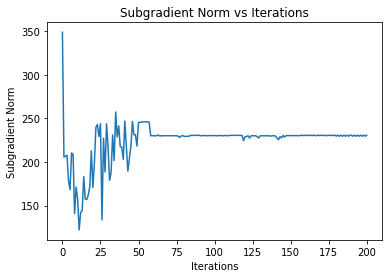

In [ ]:
# Sub gradient norm plot
r = range(i)
plt.plot(r,subgnorms)
plt.xlabel('Iterations')
plt.ylabel('Subgradient Norm')
plt.title('Subgradient Norm vs Iterations');

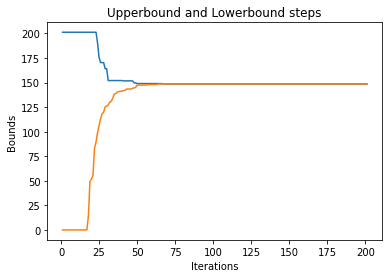

In [ ]:
## u_i, l_i graph
# Obj value plot
r = range(i+1)
plt.plot(r,upperbounds_list)
plt.plot(r,lowerbounds_list)
plt.xlabel('Iterations')
plt.ylabel('Bounds')
plt.title('Upperbound and Lowerbound steps');

Text(0.5, 1.0, 'Delta Iterations')

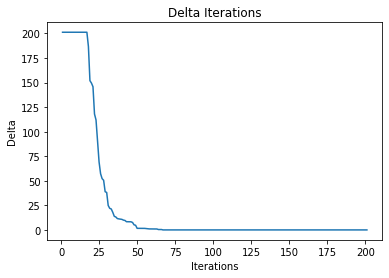

In [ ]:
r = range(i+1)
plt.plot(r,delta)
plt.xlabel('Iterations')
plt.ylabel('Delta')
plt.title('Delta Iterations')

Text(0.5, 1.0, 'Alpha Parameter over iterations')

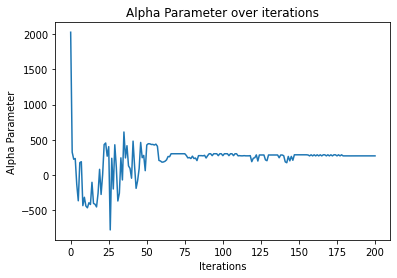

In [ ]:
r = range(i)
plt.plot(r,alpha_list)
plt.xlabel('Iterations')
plt.ylabel('Alpha Parameter')
plt.title('Alpha Parameter over iterations')

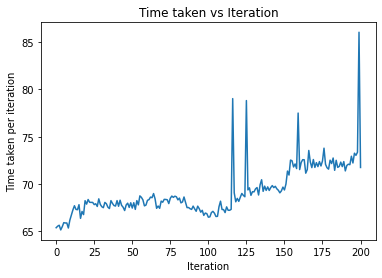

In [ ]:
# wall clock time SGD VS Bender's
r = range(i)
plt.plot(r,time_list)
plt.xlabel('Iteration')
plt.ylabel('Time taken per iteration')
plt.title('Time taken vs Iteration');

In [ ]:
from collections import defaultdict
s_values = defaultdict(list)
for lst in s_list:
    s_values['R1'].append(lst[0])
    s_values['R2'].append(lst[1])
    s_values['R3'].append(lst[2])
    s_values['R4'].append(lst[3])
    s_values['R5'].append(lst[4])
    s_values['R6'].append(lst[5])
    s_values['R7'].append(lst[6])

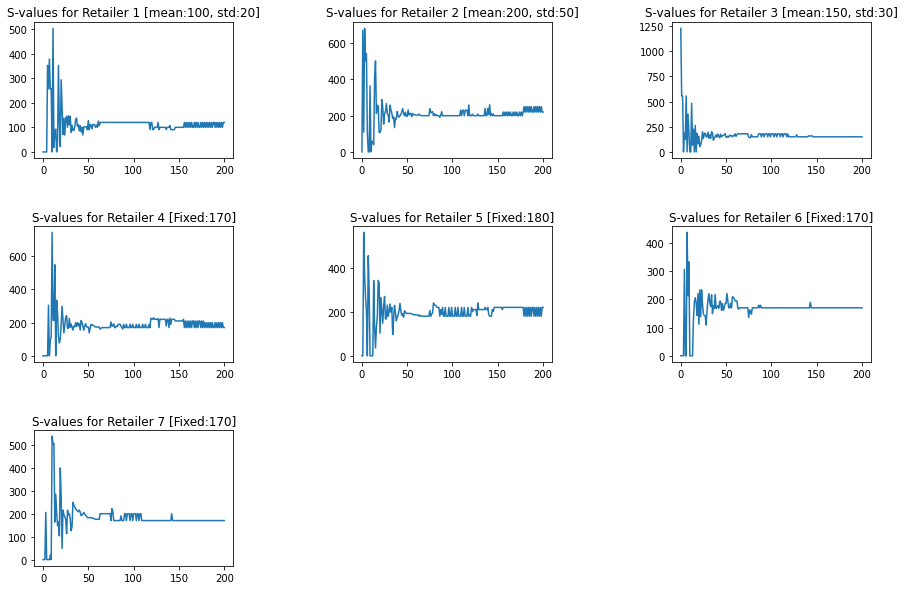

In [ ]:
# s vs d
r = range(i)
fig, ax = plt.subplots(3,3,figsize=(15,10))
plt.subplots_adjust(hspace=0.5,wspace=0.6)
ax[0,0].plot(r,s_values['R1'])
ax[0,0].set_title('S-values for Retailer 1 [mean:100, std:20]')
ax[0,1].plot(r,s_values['R2'])
ax[0,1].set_title('S-values for Retailer 2 [mean:200, std:50]')
ax[0,2].plot(r,s_values['R3'])
ax[0,2].set_title('S-values for Retailer 3 [mean:150, std:30]')
ax[1,0].plot(r,s_values['R4'])
ax[1,0].set_title('S-values for Retailer 4 [Fixed:170]')
ax[1,1].plot(r,s_values['R5'])
ax[1,1].set_title('S-values for Retailer 5 [Fixed:180]')
ax[1,2].plot(r,s_values['R6'])
ax[1,2].set_title('S-values for Retailer 6 [Fixed:170]')
ax[2,0].plot(r,s_values['R7'])
ax[2,0].set_title('S-values for Retailer 7 [Fixed:170]')
fig.delaxes(ax[2][1])
fig.delaxes(ax[2][2])

In [ ]:
df_dict = {'Objective Value': upperbounds_list[1:], 'Delta':delta[1:], 'subgradient norm':subgnorms, 'Time taken':time_list, 'S-vectors':s_list, 'Upperbound':upperbounds_list[1:], 'Lowerbound':lowerbounds_list[1:]}
df = pd.DataFrame.from_dict(df_dict)
df.to_csv('Benders data.csv')
df

,Objective Value,Delta,subgradient norm,Time taken,S-vectors,Upperbound,Lowerbound
0,201.212380,2.012124e+02,348.769623,65.393189,"[0.0, 0.0, 1227.76845792214, 0.0, 0.0, 0.0, 0.0]",201.212380,0.000000
1,201.212380,2.012124e+02,205.665991,65.558977,"[0.0, 670.990624951724, 556.777832970415, 0.0,...",201.212380,0.000000
2,201.212380,2.012124e+02,206.661559,65.655460,"[0.0, 109.267557561458, 556.777832970415, 0.0,...",201.212380,0.000000
3,201.212380,2.012124e+02,207.755265,65.162348,"[0.0, 681.773763901162, 0.0, 0.0, 361.55201419...",201.212380,0.000000
4,201.212380,2.012124e+02,178.995112,65.501413,"[0.0, 502.44339463474, 185.798505911628, 0.0, ...",201.212380,0.000000
...,...,...,...,...,...,...,...
196,148.572022,-1.136868e-13,230.787240,73.255941,"[100.0, 250.000000000012, 150.0, 200.000000000...",148.572022,148.572022
197,148.572022,-1.136868e-13,229.629049,73.029031,"[120.000000000006, 219.999999999998, 150.0, 16...",148.572022,148.572022
198,148.572022,-1.136868e-13,230.787240,73.361858,"[100.0, 250.000000000012, 150.0, 200.000000000...",148.572022,148.572022
199,148.572022,-1.136868e-13,229.629049,86.017028,"[120.000000000006, 219.999999999998, 150.0, 16...",148.572022,148.572022
